# Demo of Earthquake Detection at Cook Inlet

Author: Qibin Shi

Tech support: Yiyu Ni

In [ ]:
import sys
sys.path.append('../src/denoiser/')
sys.path.append('../src/ensemble_picker/')

import gc
import glob
import h5py
import pygmt
import numpy as np
import pandas as pd

import torch
import pyocto
import seisbench.models as sbm
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.trigger_func import picks_summary_simple

from datetime import datetime
from das_util import try_gpu
from detect_util import *
from joblib import Parallel, delayed
from tqdm import tqdm

import obspy
from obspy import UTCDateTime, read_events
from obspy.clients.fdsn.client import Client

###
filepath = '/fd1/QibinShi_data/akdas/qibin_data/elep_pyocto/coast_only/'

## 1. Buidling catalog with Only Coastal Stations

#### Station availability

In [ ]:
client = Client("IRIS")
t1 = UTCDateTime("2023-12-01")
t2 = UTCDateTime("2023-12-31")

inventory = client.get_stations(network="AK,AV", channel="BH?",
                                starttime=t1, endtime=t2, 
                                maxlatitude=60.1809, minlatitude=58.5911, 
                                maxlongitude=-150.6555, minlongitude=-153.7177)

#### Detect 30 days

In [ ]:
### ELEP models
devcc = try_gpu(i=1)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")

pn_ethz_model.to(devcc)
pn_neic_model.to(devcc)
pn_scedc_model.to(devcc)
pn_stead_model.to(devcc)
pn_geofon_model.to(devcc)
pn_instance_model.to(devcc)

pn_ethz_model.eval()
pn_neic_model.eval()
pn_scedc_model.eval()
pn_stead_model.eval()
pn_geofon_model.eval()
pn_instance_model.eval()

list_models = [pn_ethz_model,
               pn_neic_model,
               pn_scedc_model,
               pn_stead_model,
               pn_geofon_model,
               pn_instance_model]

### Loop over days
for i in range(30):
    t1 = UTCDateTime("2023-12-07") + i * 86400
    ### loop over stations
    for net in inventory:
        network = net.code

        for sta in net:
            station = sta.code
            
            print(network, station, t1)  
            
            detect_on_fly(network, station, t1, filepath, 6000, 3000, list_models, devcc)

#### Prepare picks for association

In [ ]:
### Merge picks from all stations
csv_list = glob.glob(filepath+'1month/*2023*.csv')
all_csv =[]
for i in csv_list:
    all_csv.append(pd.read_csv(i, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})

df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks['time'] = picks['time'].apply(lambda x: (datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())

picks.to_csv(filepath + 'picks_octo.csv', index=False)
picks.head()

#### Prepare stations for association

In [ ]:
### Station table for PyOcto
# client = Client("IRIS")
# t1 = UTCDateTime("2023-12-01")
# t2 = UTCDateTime("2023-12-31")
# inventory = client.get_stations(network="AK,AV", channel="BH?",
#                                 starttime=t1, endtime=t2, 
#                                 maxlatitude=60.1809, minlatitude=58.5911, 
#                                 maxlongitude=-150.6555, minlongitude=-153.7177)
# stations_table = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])

# for net in inventory:
#     for sta in net:
#         station = sta.code
#         temp = pd.DataFrame(data={'id': sta.code,
#                                   'longitude': sta.longitude,
#                                   'latitude': sta.latitude, 
#                                   'elevation': sta.elevation},index=[0])
#         stations_table = pd.concat([stations_table,temp],ignore_index=True)

stations_table = pd.read_csv(filepath + 'stations_table.csv')

velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)
# associator = pyocto.OctoAssociator.from_area(
#     lat=(57, 61),
#     lon=(-155, -149),
#     zlim=(0, 200),
#     time_before=300,
#     velocity_model=velocity_model,
#     n_picks=6,
#     n_p_picks=3,
#     n_s_picks=3,
#     n_p_and_s_picks=3,
# )

# associator = pyocto.OctoAssociator.from_area(
#     lat=(57, 61),
#     lon=(-155, -149),
#     zlim=(0, 200),
#     time_before=300,
#     velocity_model=velocity_model,
#     n_picks=10,
#     n_p_picks=5,
#     n_s_picks=5,
#     n_p_and_s_picks=3,
# )

# associator = pyocto.OctoAssociator.from_area(
#     lat=(57, 61),
#     lon=(-155, -149),
#     zlim=(0, 200),
#     time_before=300,
#     velocity_model=velocity_model,
#     n_picks=20,
#     n_p_picks=2,
#     n_s_picks=10,
#     n_p_and_s_picks=2,
# )

associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -150),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_picks=3,
    n_s_picks=5,
    n_p_and_s_picks=3,
)
    
associator.transform_stations(stations_table)
# stations_table.to_csv(filepath + 'stations_table.csv', index=False)
stations_table.head()


### Associate!

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(datetime.fromtimestamp)

all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo_staonly.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_staonly.csv', index=False)

In [ ]:
### Save the results
events = pd.read_csv(filepath + 'events_detect_octo_staonly.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_staonly.csv')
print(len(events), len(all_pick_assignments))

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", 
             FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", 
             MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])
shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

## 2. Catalog with Initial DAS picks

### DAS cable and initial picks -- save as the format same as stations

In [ ]:
### Cable coordinates from Ethan Williams
### We only use Ch. 500-5000
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### picks
filepaths = ['/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_0_200.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_200_400.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_400_555.hdf5']

raw_alldata_picks = np.concatenate([f["raw_alldata_picks"][:] for f in map(h5py.File, filepaths)])
mul_denoise_picks = np.concatenate([f["mul_denoise_picks"][:] for f in map(h5py.File, filepaths)])

### recording times
record_time_file = '/fd1/QibinShi_data/akdas/qibin_data/recording_times_smaller.csv'
df_record_time = pd.read_csv(record_time_file)
b_times = [UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for start_t in df_record_time['record_time'].values]
b_times_terra = [b_terra + 0.88 for b_terra in b_times]
b_times_kkfls = [b_terra + 1.20 for b_terra in b_times]

### convert and save
thr = 0.05
ch_dsamp = 10
ch_ind = np.arange(0, 4500, ch_dsamp)
len_cat = raw_alldata_picks.shape[0]

channel_table = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])

for ch in ch_ind:

    if ch >= 2250:  # terra
        ch1 = int(ch * 2 - 4000) 
        longitude = terra.loc[ch1, 'lon']
        latitude = terra.loc[ch1, 'lat']
        elevation = terra.loc[ch1, 'dep']
        b_t = b_times_terra
    else:  # kkfls
        ch1 = 5000 - ch * 2
        longitude = kkfls.loc[ch1, 'lon']
        latitude = kkfls.loc[ch1, 'lat']
        elevation = kkfls.loc[ch1, 'dep']
        b_t = b_times_kkfls

    temp = pd.DataFrame(data={'id': 'das'+str(ch),
                              'longitude': longitude,
                              'latitude': latitude, 
                              'elevation': elevation},index=[0])
    channel_table = pd.concat([channel_table,temp],ignore_index=True)

    p_raw = [b_t[i] + raw_alldata_picks[i, ch, 0, 0] if raw_alldata_picks[i, ch, 0, 1] > thr else np.nan for i in range(len_cat)]
    s_raw = [b_t[i] + raw_alldata_picks[i, ch, 1, 0] if raw_alldata_picks[i, ch, 1, 1] > thr else np.nan for i in range(len_cat)]
    p_den = [b_t[i] + mul_denoise_picks[i, ch, 0, 0] if mul_denoise_picks[i, ch, 0, 1] > thr else np.nan for i in range(len_cat)]
    s_den = [b_t[i] + mul_denoise_picks[i, ch, 1, 0] if mul_denoise_picks[i, ch, 1, 1] > thr else np.nan for i in range(len_cat)]
    
    df_raw = pd.DataFrame({
        'event_id': [' '] * len_cat,
        'source_type': [' '] * len_cat,
        'station_network_code': ['CIDAS'] * len_cat,
        'station_channel_code': [' '] * len_cat,
        'station_code': ['das'+str(ch)] * len_cat,
        'station_location_code': [' '] * len_cat,
        'station_latitude_deg': [latitude] * len_cat,
        'station_longitude_deg': [longitude] * len_cat,
        'station_elevation_m': [elevation] * len_cat,
        'trace_name': [' '] * len_cat,
        'trace_sampling_rate_hz': [25] * len_cat,
        'trace_start_time': b_t,
        'trace_S_arrival_sample': [' '] * len_cat,
        'trace_P_arrival_sample': [' '] * len_cat,
        'trace_S_onset': [' '] * len_cat,
        'trace_P_onset': [' '] * len_cat,
        'trace_snr_db': [' '] * len_cat,
        'trace_s_arrival': s_raw,
        'trace_p_arrival': p_raw
    })

    df_deno = pd.DataFrame({
        'event_id': [' '] * len_cat,
        'source_type': [' '] * len_cat,
        'station_network_code': ['CIDAS'] * len_cat,
        'station_channel_code': [' '] * len_cat,
        'station_code': ['das'+str(ch)] * len_cat,
        'station_location_code': [' '] * len_cat,
        'station_latitude_deg': [latitude] * len_cat,
        'station_longitude_deg': [longitude] * len_cat,
        'station_elevation_m': [elevation] * len_cat,
        'trace_name': [' '] * len_cat,
        'trace_sampling_rate_hz': [25] * len_cat,
        'trace_start_time': b_t,
        'trace_S_arrival_sample': [' '] * len_cat,
        'trace_P_arrival_sample': [' '] * len_cat,
        'trace_S_onset': [' '] * len_cat,
        'trace_P_onset': [' '] * len_cat,
        'trace_snr_db': [' '] * len_cat,
        'trace_s_arrival': s_den,
        'trace_p_arrival': p_den
    })

    df_raw.to_csv(filepath+'1month/' + 'CIDAS_Ch_' + str(ch) + '_raw' + '.csv')
    df_deno.to_csv(filepath+'1month/' + 'CIDAS_Ch_' + str(ch) + '_deno' + '.csv')
    channel_table.to_csv(filepath + 'das_channel_table.csv', index=False)

#### Prepare channel and stations for association

In [ ]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=0.5,
)
associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -149),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_picks=0,
    n_s_picks=10,
    n_p_and_s_picks=0,
)

### DAS channels
channel_table = pd.read_csv(filepath + 'das_channel_table.csv')[::10]
associator.transform_stations(channel_table)

### Coastal stations
picks_sta = pd.read_csv(filepath + 'picks_octo.csv')
sta_table = pd.read_csv(filepath + 'stations_table.csv')

### Merge
stations_table = pd.concat([sta_table, channel_table], axis=0, ignore_index=True)
stations_table

#### Prepare picks for association

In [ ]:
### Merge picks
ch_ind = np.arange(0, 4500, 100)
all_csv =[]
for i in ch_ind:
    filename = filepath+'1month/CIDAS_Ch_' + str(i) + '_deno.csv'
    all_csv.append(pd.read_csv(filename, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})

df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks_das = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks_das['time'] = picks_das['time'].apply(lambda x: (datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())

picks_das.to_csv(filepath + 'picks_octo_das.csv', index=False)

### Merge DAS and Stas
picks = pd.concat([picks_sta, picks_das], axis=0, ignore_index=True)
picks

### Associate!!

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(datetime.fromtimestamp)

all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments.csv', index=False)

In [ ]:
### Save the results
events = pd.read_csv(filepath + 'events_detect_octo.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments.csv')

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

## 3. Catalog with Quality-Controlled DAS picks

In [ ]:
### Cable coordinates from Ethan Williams
### We only use Ch. 500-5000
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### picks
filepaths = ['/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_0_200.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_200_400.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_400_555.hdf5']

raw_alldata_picks = np.concatenate([f["raw_alldata_picks"][:] for f in map(h5py.File, filepaths)])
mul_denoise_picks = np.concatenate([f["mul_denoise_picks"][:] for f in map(h5py.File, filepaths)])
pred_picks = np.concatenate([f["predicted_picks"][:] for f in map(h5py.File, filepaths)])

### catalog
cat1 = read_events("/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/denoised_catalog_0_200.xml")
cat2 = read_events("/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/denoised_catalog_200_400.xml")
cat3 = read_events("/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/denoised_catalog_400_555.xml")
cat = cat1 + cat2 + cat3

### Recording time
df_record_time = pd.read_csv('/fd1/QibinShi_data/akdas/qibin_data/recording_times_smaller.csv')
b_times = [UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for start_t in df_record_time['record_time'].values]
b_times_terra = [b_terra + 0.88 for b_terra in b_times]
b_times_kkfls = [b_terra + 1.20 for b_terra in b_times]
org_times = [evt.origins[0].time - b_t for evt, b_t in zip(cat, b_times)]
pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]

#### QC

In [ ]:
def fit_series(s1, s2, prob, thr=0.05, vmin=0, vmax=60):
    offsets = s1-s2
    ind = np.where(np.logical_and(np.logical_and(np.logical_and(vmin<s1, s1<vmax), prob > thr), np.fabs(offsets) < 3.0))[0]
    ind_rest = np.setdiff1d(np.arange(len(s1)), ind)

    s1[ind_rest] = np.nan

    return s1, ind, ind_rest

qc_picks = np.zeros_like(mul_denoise_picks)

for i in tqdm(np.arange(len(raw_alldata_picks))):
    
    qc_picks[i, :, 1, 0], ind1, ind2 = fit_series(
        mul_denoise_picks[i,:,1,0], pred_picks[i,:,1], raw_alldata_picks[i,:,1,1], thr=0.05, vmin=5, vmax=55)
    
    qc_picks[i, :, 0, 0], ind3, ind4 = fit_series(
        mul_denoise_picks[i,:,0,0], pred_picks[i,:,0], raw_alldata_picks[i,:,0,1], thr=0.1, vmin=5, vmax=55)

#### Merge qc picked with DAS locations

In [ ]:
ch_dsamp = 10
ch_ind = np.arange(0, 4500, ch_dsamp)
len_cat = qc_picks.shape[0]

for ch in ch_ind:

    if ch >= 2250:  # terra
        ch1 = int(ch * 2 - 4000) 
        longitude = terra.loc[ch1, 'lon']
        latitude = terra.loc[ch1, 'lat']
        elevation = terra.loc[ch1, 'dep']
        b_t = b_times_terra
    else:  # kkfls
        ch1 = 5000 - ch * 2
        longitude = kkfls.loc[ch1, 'lon']
        latitude = kkfls.loc[ch1, 'lat']
        elevation = kkfls.loc[ch1, 'dep']
        b_t = b_times_kkfls

    p_den = [b_t[i] + qc_picks[i, ch, 0, 0] if qc_picks[i, ch, 0, 0] == qc_picks[i, ch, 0, 0] else np.nan for i in range(len_cat)]
    s_den = [b_t[i] + qc_picks[i, ch, 1, 0] if qc_picks[i, ch, 1, 0] == qc_picks[i, ch, 1, 0] else np.nan for i in range(len_cat)]

    df_deno = pd.DataFrame({
        'event_id': [' '] * len_cat,
        'source_type': [' '] * len_cat,
        'station_network_code': ['CIDAS'] * len_cat,
        'station_channel_code': [' '] * len_cat,
        'station_code': ['das'+str(ch)] * len_cat,
        'station_location_code': [' '] * len_cat,
        'station_latitude_deg': [latitude] * len_cat,
        'station_longitude_deg': [longitude] * len_cat,
        'station_elevation_m': [elevation] * len_cat,
        'trace_name': [' '] * len_cat,
        'trace_sampling_rate_hz': [25] * len_cat,
        'trace_start_time': b_t,
        'trace_S_arrival_sample': [' '] * len_cat,
        'trace_P_arrival_sample': [' '] * len_cat,
        'trace_S_onset': [' '] * len_cat,
        'trace_P_onset': [' '] * len_cat,
        'trace_snr_db': [' '] * len_cat,
        'trace_s_arrival': s_den,
        'trace_p_arrival': p_den
    })

    df_deno.to_csv(filepath+'1month/' + 'CIDAS_Ch_' + str(ch) + '_deno_qc' + '.csv')

### Prepare stations, channel and picks for association

In [ ]:
### Initialize Octo
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)
associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -150),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_picks=3,
    n_s_picks=5,
    n_p_and_s_picks=3,
)

### DAS channel table
channel_table = pd.read_csv(filepath + 'das_channel_table.csv')[::10]
associator.transform_stations(channel_table)

### DAS picks
ch_ind = np.arange(0, 4500, 100)
all_csv =[]
for i in ch_ind:
    filename = filepath+'1month/CIDAS_Ch_' + str(i) + '_deno_qc.csv'
    all_csv.append(pd.read_csv(filename, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})

df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks_das = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks_das['time'] = picks_das['time'].apply(lambda x: (datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())

picks_das.to_csv(filepath + 'picks_octo_das_qc.csv', index=False)


### Coastal data
picks_sta = pd.read_csv(filepath + 'picks_octo.csv')
sta_table = pd.read_csv(filepath + 'stations_table.csv')

### Merge DAS and Sta
picks = pd.concat([picks_sta, picks_das], axis=0, ignore_index=True)
stations_table = pd.concat([sta_table, channel_table], axis=0, ignore_index=True)

### Associate !!!

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(datetime.fromtimestamp)

all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo_qc1.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_qc1.csv', index=False)

In [ ]:
### Save the results
events = pd.read_csv(filepath + 'events_detect_octo_qc1.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_qc1.csv')

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

## 4. Demo for 1 hour, Start from scratch

In [1]:
import sys
sys.path.append('../src/denoiser/')
sys.path.append('../src/ensemble_picker/')

import gc
import glob
import h5py
import pygmt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import pyocto
import seisbench.models as sbm
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.trigger_func import picks_summary_simple

from datetime import datetime
from das_util import *
from detect_util import *
from das_denoise_models import unet
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d

import obspy
from obspy import UTCDateTime, read_events
from obspy.clients.fdsn.client import Client

###
filepath = '/fd1/QibinShi_data/akdas/qibin_data/elep_pyocto/coast_only/'

/home/qibins/anaconda3/envs/denoise/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/qibins/anaconda3/envs/denoise/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Read data and time

In [2]:
rawdata_dir = '/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/'
kkfls_dir = rawdata_dir + 'KKFL-S/'
terra_dir = rawdata_dir + 'TERRA/'
kkfls_files = glob.glob(kkfls_dir + 'decimator2_*.h5')
terra_files = glob.glob(terra_dir + 'decimator2_*.h5')
kkfls_files.sort()
terra_files.sort()

kkfls_data = np.zeros((len(kkfls_files), 4500, 1500), dtype=np.float32)
terra_data = np.zeros((len(terra_files), 4500, 1500), dtype=np.float32)
kkfls_btimes = np.zeros(len(kkfls_files), dtype=object)
terra_btimes = np.zeros(len(terra_files), dtype=object)

for i, kkfls_file in enumerate(kkfls_files):
    print(kkfls_file)
    with h5py.File(kkfls_file, 'r') as f:
        time_data = f['Acquisition']['Raw[0]']['RawData'][:1500, 500:5000]
        kkfls_data[i, :time_data.shape[1], :time_data.shape[0]] = time_data.T
        kkfls_btimes[i] = datetime.utcfromtimestamp(f['Acquisition']['Raw[0]']['RawDataTime'][0]/1e6)
for i, terra_file in enumerate(terra_files):
    print(terra_file)
    with h5py.File(terra_file, 'r') as f:
        time_data = f['Acquisition']['Raw[0]']['RawData'][:1500, 500:5000]
        terra_data[i, :time_data.shape[1], :time_data.shape[0]] = time_data.T
        terra_btimes[i] = datetime.utcfromtimestamp(f['Acquisition']['Raw[0]']['RawDataTime'][0]/1e6)

### merge two arrays and filter
rawdata = np.append(kkfls_data[:, ::-1, :], terra_data[:,:,:], axis=1)
rawdata = np.nan_to_num(rawdata)

### Bandpass filter
b, a = butter(4, (0.5, 12), fs=25, btype='bandpass')
filt = filtfilt(b, a, rawdata, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)  ## Rawdata w.r.t. Denoised 

rawdata.shape

/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.00.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.01.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.02.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.03.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.04.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.05.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.06.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.07.08_UTC.h5
/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/KKFL-S/decimator2_2023-07-14_23.08.08_UTC.h5
/home/niyiyu/Resear

(60, 9000, 1500)

#### Denoise

In [3]:
""" Initialize the U-net model """
devc = try_gpu(i=1)

model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[1,2,3])
model_1.to(devc)

""" Load the pretrained weights """
model_1.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2raw_chmax4500.pt'))  # raw2raw
model_1.eval() 

""" Denoise """
one_denoised = np.zeros_like(rawdata)
mul_denoised = np.zeros_like(rawdata)

for eid in np.arange(len(rawdata)):
    one_denoised[eid,:,:], mul_denoised[eid,:,:] = Denoise_largeDAS(rawdata[eid], 
                                                                    model_1, 
                                                                    devc, 
                                                                    repeat=4, 
                                                                    norm_batch=False)


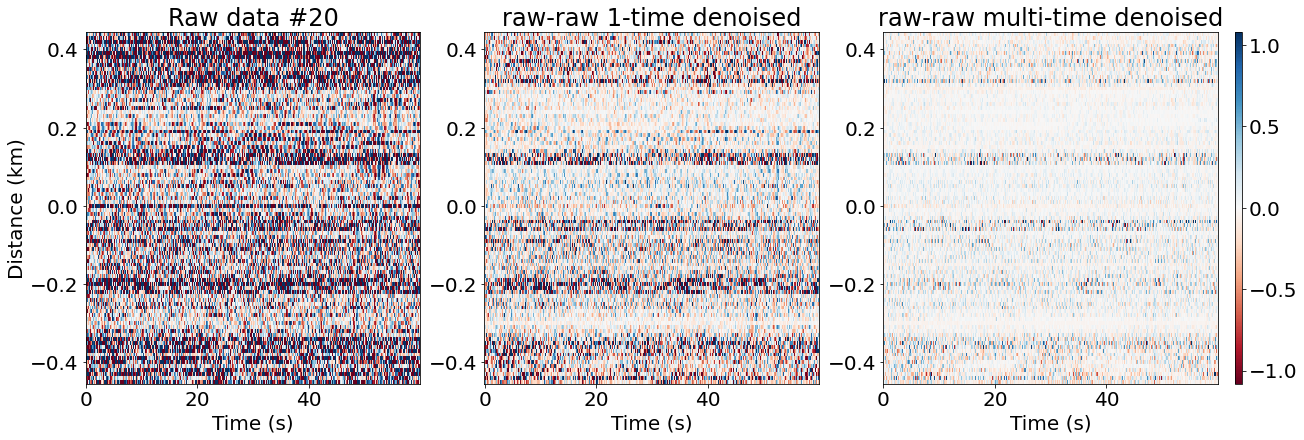

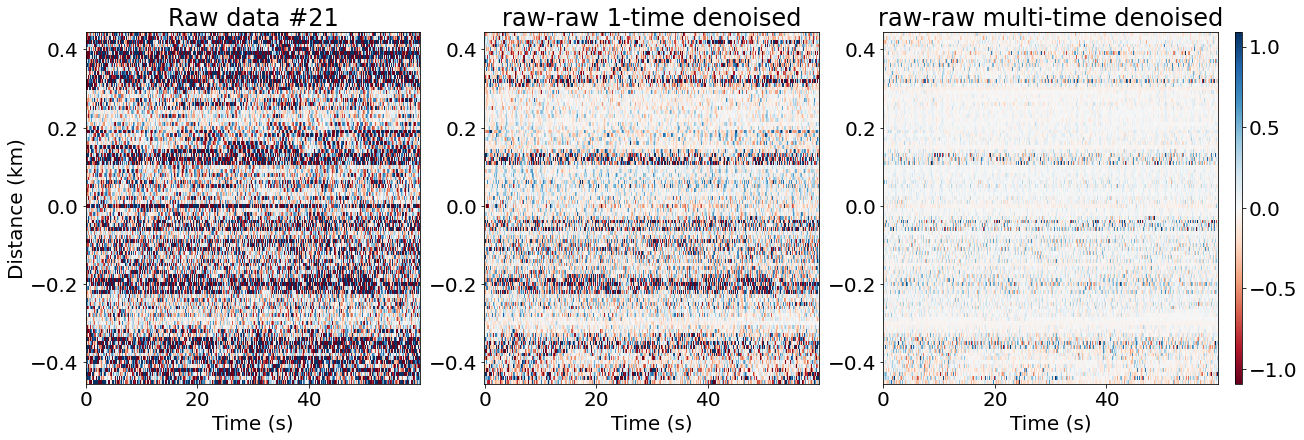

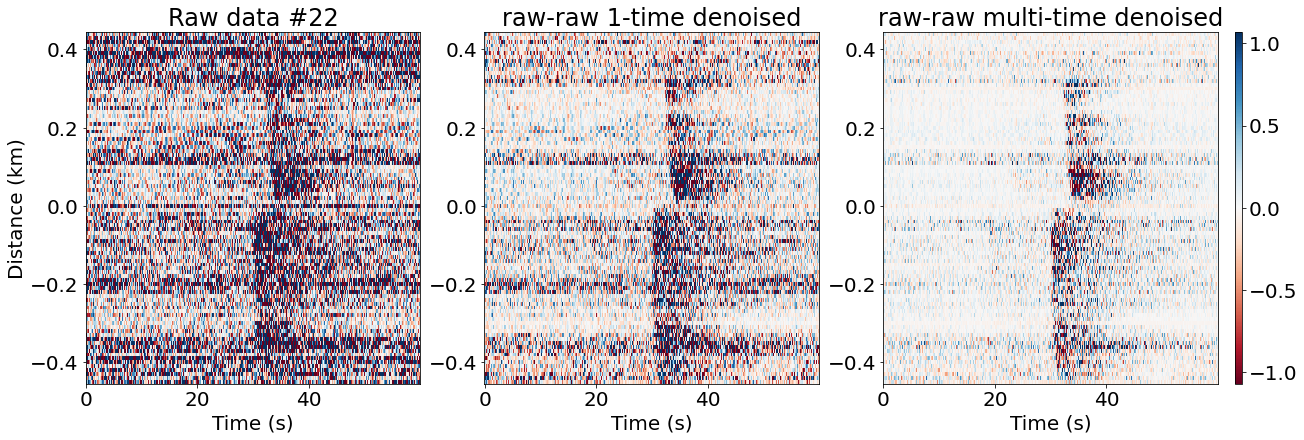

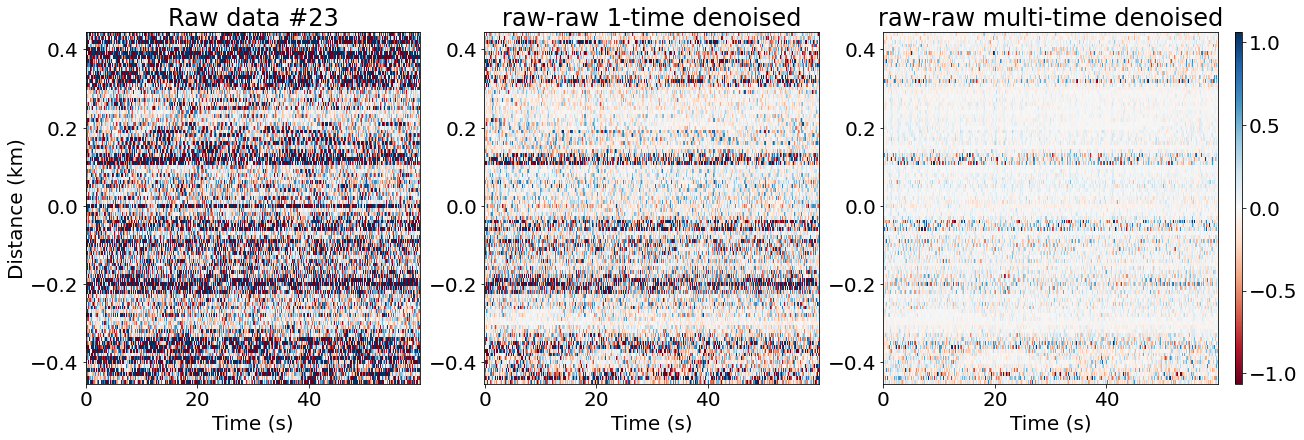

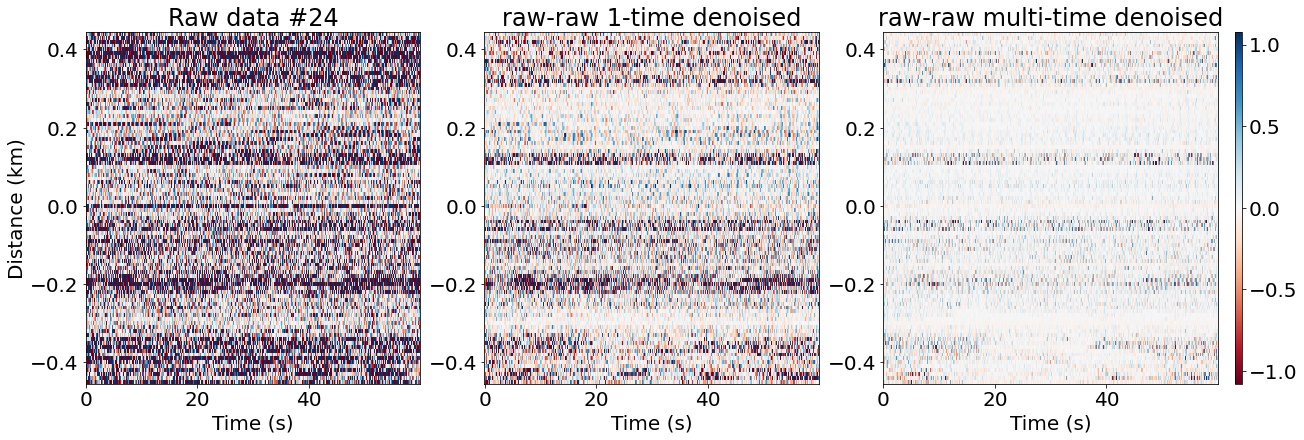

In [6]:
%matplotlib inline
vizRawDenoise(rawdata[:,::100,:], one_denoised[:,::100,:], mul_denoised[:,::100,:], index=range(20,25), model="raw-raw")

#### Pick phases

In [7]:
### The phase picker needs 6000 time points as input
interp_func = interp1d(np.linspace(0, 1, 1500), rawdata, axis=-1, kind='linear')
interpolated_image = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

In [8]:
### ML picker parameters
paras_semblance = {'dt':0.01, 
                   'semblance_order':2, 
                   'window_flag':True, 
                   'semblance_win':0.5, 
                   'weight_flag':'max'}

### ELEP models
devcc = try_gpu(i=1)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")

pn_ethz_model.to(devcc)
pn_neic_model.to(devcc)
pn_scedc_model.to(devcc)
pn_stead_model.to(devcc)
pn_geofon_model.to(devcc)
pn_instance_model.to(devcc)

pn_ethz_model.eval()
pn_neic_model.eval()
pn_scedc_model.eval()
pn_stead_model.eval()
pn_geofon_model.eval()
pn_instance_model.eval()

list_models = [pn_ethz_model,
               pn_neic_model,
               pn_scedc_model,
               pn_stead_model,
               pn_geofon_model,
               pn_instance_model]

In [9]:
Nevent=len(rawdata)

fs=100
ch_itv=200  # data are downsampled to pick
dchan=9.5714

nsta = interpolated_image.shape[1] // ch_itv
raw_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
mul_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)

for i in tqdm(np.arange(Nevent)):

    ### Pick RAW data
    image = np.nan_to_num(interpolated_image[i,::ch_itv,:])
    raw_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)
    
    ### Pick mulDENOISED 
    image = np.nan_to_num(interpolated_muldenoised[i,::ch_itv,:])
    mul_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)

100%|██████████| 60/60 [13:14<00:00, 13.24s/it]  


In [15]:
### Cable coordinates from Ethan Williams
### We only use Ch. 500-5000
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### convert and save
thr = 0.05
ch_ind = np.arange(raw_picks.shape[1])
len_cat = raw_picks.shape[0]

for ch in ch_ind:

    if ch > 22:  # terra
        ch1 = int(ch * 200 - 4000) 
        longitude = terra.loc[ch1, 'lon']
        latitude = terra.loc[ch1, 'lat']
        elevation = terra.loc[ch1, 'dep']
        b_t = terra_btimes
    else:  # kkfls
        ch1 = 5000 - ch * 200
        longitude = kkfls.loc[ch1, 'lon']
        latitude = kkfls.loc[ch1, 'lat']
        elevation = kkfls.loc[ch1, 'dep']
        b_t = kkfls_btimes


    p_den = [b_t[i] + timedelta(seconds=np.float64(mul_picks[i, ch, 0, 0])) if mul_picks[i, ch, 0, 1] > thr else np.nan for i in range(len_cat)]
    s_den = [b_t[i] + timedelta(seconds=np.float64(mul_picks[i, ch, 1, 0])) if mul_picks[i, ch, 1, 1] > thr else np.nan for i in range(len_cat)]
    
    df_deno = pd.DataFrame({
        'event_id': [' '] * len_cat,
        'source_type': [' '] * len_cat,
        'station_network_code': ['CIDAS'] * len_cat,
        'station_channel_code': [' '] * len_cat,
        'station_code': ['das'+str(ch*100)] * len_cat,
        'station_location_code': [' '] * len_cat,
        'station_latitude_deg': [latitude] * len_cat,
        'station_longitude_deg': [longitude] * len_cat,
        'station_elevation_m': [elevation] * len_cat,
        'trace_name': [' '] * len_cat,
        'trace_sampling_rate_hz': [25] * len_cat,
        'trace_start_time': b_t,
        'trace_S_arrival_sample': [' '] * len_cat,
        'trace_P_arrival_sample': [' '] * len_cat,
        'trace_S_onset': [' '] * len_cat,
        'trace_P_onset': [' '] * len_cat,
        'trace_snr_db': [' '] * len_cat,
        'trace_s_arrival': s_den,
        'trace_p_arrival': p_den
    })

    df_deno.to_csv(filepath+'1hour/' + 'CIDAS_Ch_' + str(ch) + '_deno' + '.csv')

<ipython-input-15-8db04d74ef78>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
<ipython-input-15-8db04d74ef78>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)


In [2]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=0.5,
)
associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -149),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=6,
    n_p_picks=3,
    n_s_picks=3,
    n_p_and_s_picks=2,
)

### DAS channels
channel_table = pd.read_csv(filepath + 'das_channel_table.csv')[::10]
associator.transform_stations(channel_table)

### Coastal stations
picks_sta = pd.read_csv(filepath + 'picks_octo.csv')
sta_table = pd.read_csv(filepath + 'stations_table.csv')

### Merge
stations_table = pd.concat([sta_table, channel_table], axis=0, ignore_index=True)
stations_table

,id,longitude,latitude,elevation,x,y,z
0,BRLK,-150.906300,59.751100,409.000000,61.484460,84.180695,-0.409000
1,BRSE,-150.741400,59.741700,541.000000,70.773819,83.297981,-0.541000
2,CNP,-151.237300,59.525100,564.000000,43.166508,58.743584,-0.564000
3,HOM,-151.651500,59.657200,221.000000,19.647067,73.264170,-0.221000
4,O20K,-152.624000,60.081500,915.000000,-34.733179,120.647826,-0.915000
...,...,...,...,...,...,...,...
65,das4000,-152.187016,59.589449,-36.845622,-10.564498,65.679624,0.036846
66,das4100,-152.220510,59.590856,-44.977869,-12.456076,65.842179,0.044978
67,das4200,-152.252812,59.596078,-52.630924,-14.278506,66.430416,0.052631
68,das4300,-152.284924,59.596360,-47.876753,-16.091973,66.469136,0.047877


In [4]:
picks_sta

,station,phase,time


In [3]:
### Merge picks
ch_ind = np.arange(45)
all_csv =[]
for i in ch_ind:
    filename = filepath+'1hour/CIDAS_Ch_' + str(i) + '_deno.csv'
    all_csv.append(pd.read_csv(filename, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})

df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks_das = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks_das['time'] = picks_das['time'].apply(lambda x: (datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f')).timestamp())

picks_das.to_csv(filepath + 'picks_octo_das.csv', index=False)

### Merge DAS and Stas
picks = pd.concat([picks_sta, picks_das], axis=0, ignore_index=True)
picks

,station,phase,time
0,das0,P,1.689401e+09
1,das0,P,1.689401e+09
2,das0,P,1.689402e+09
3,das0,P,1.689402e+09
4,das0,P,1.689403e+09
...,...,...,...
319,das3400,S,1.689402e+09
320,das3500,S,1.689402e+09
321,das3600,S,1.689402e+09
322,das3700,S,1.689402e+09


In [4]:
# Association 
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(datetime.fromtimestamp)

all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo_1hr.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_1hr.csv', index=False)

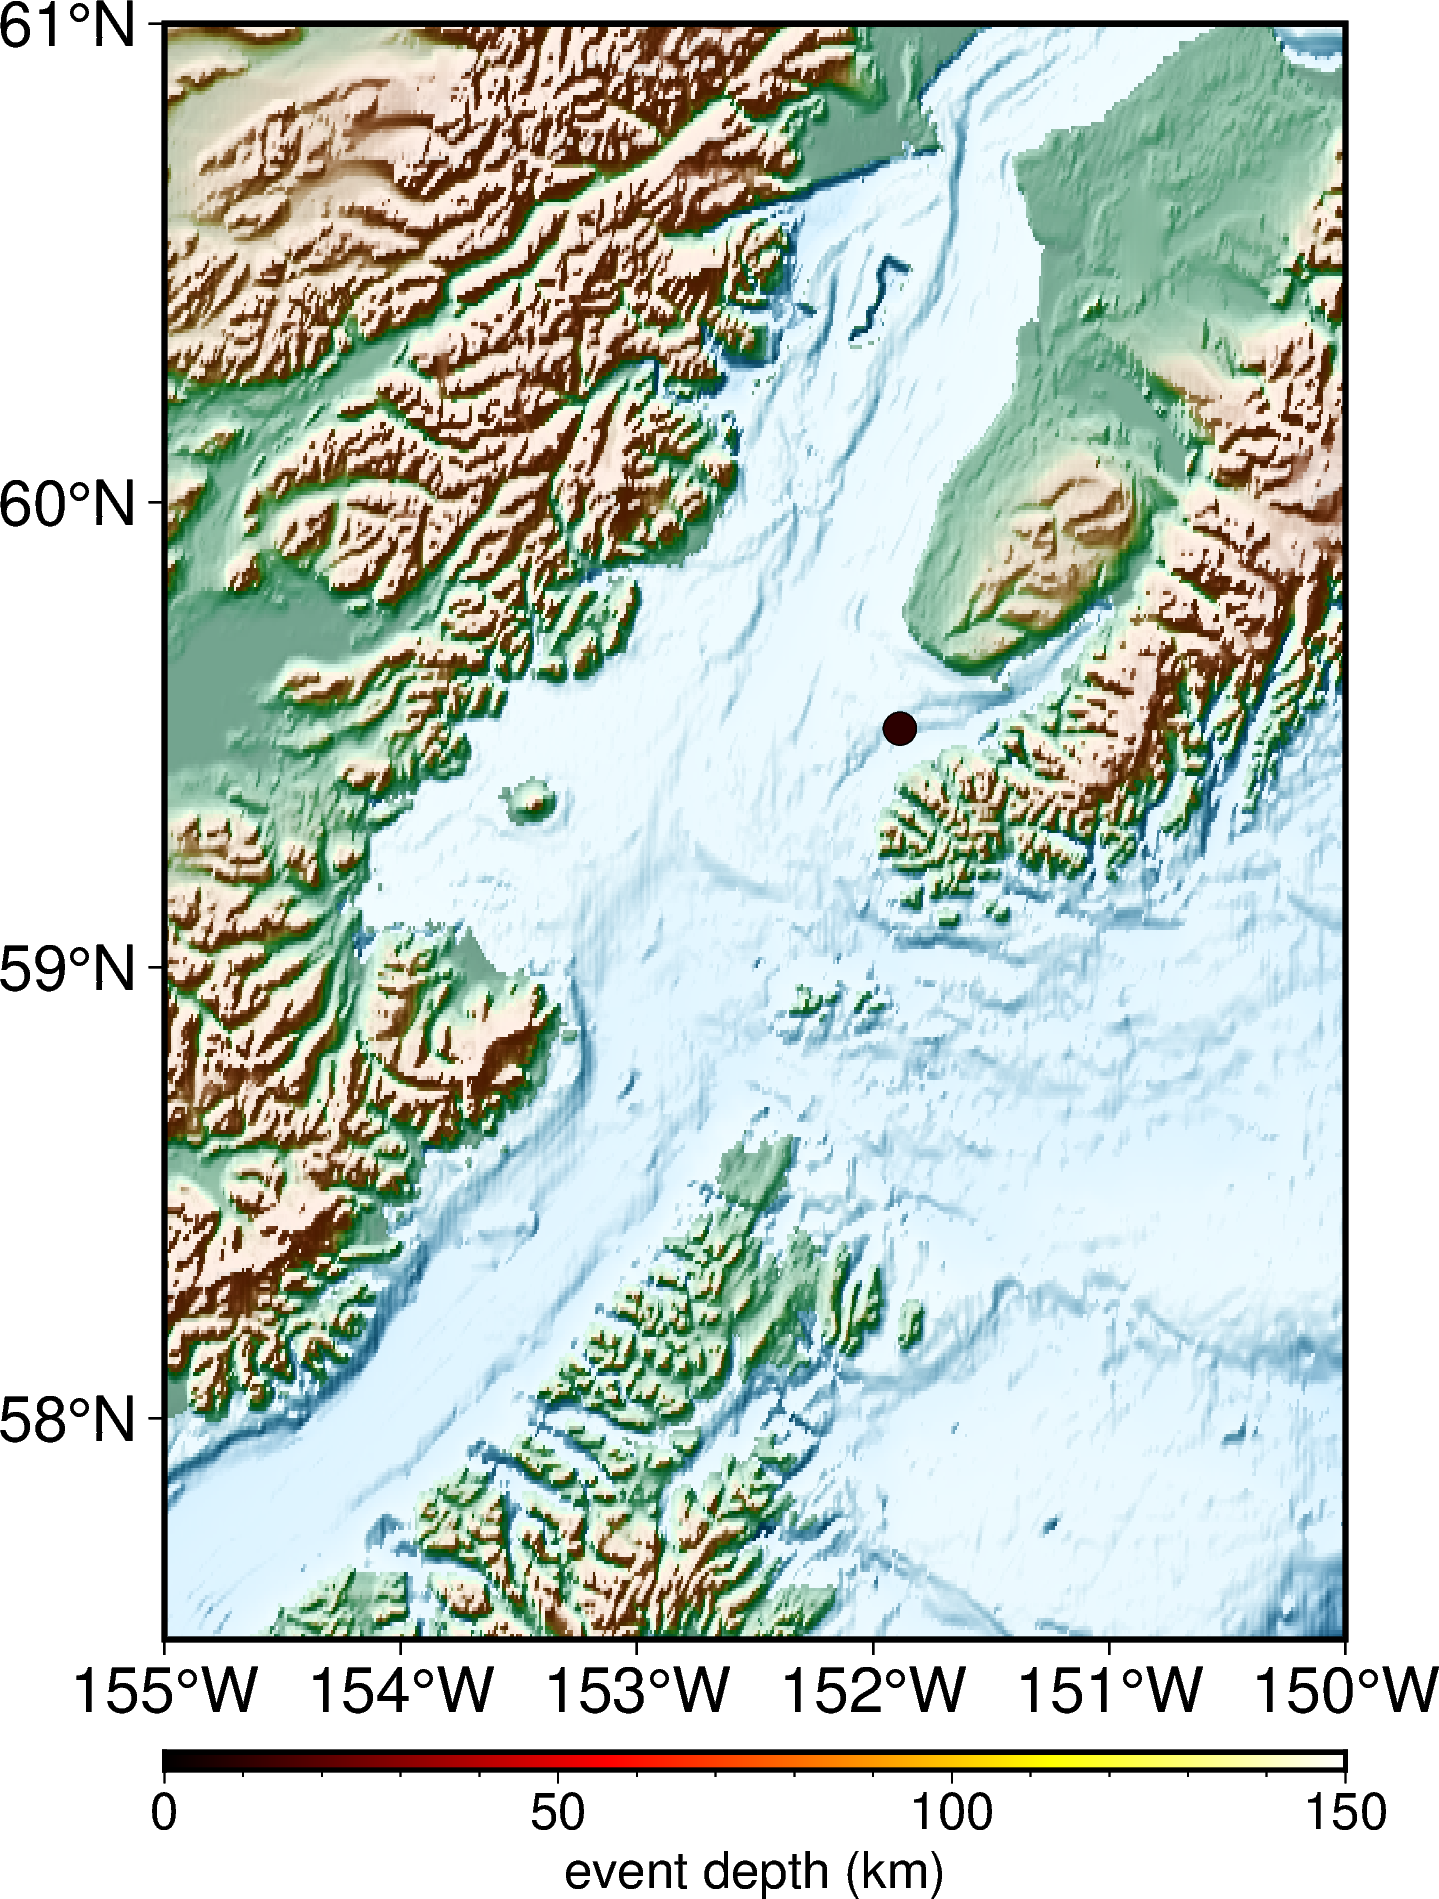

In [5]:
### Save the results
events = pd.read_csv(filepath + 'events_detect_octo_1hr.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_1hr.csv')

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()